In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [2]:
df = pd.read_csv('predictive_maintenance.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
date       124494 non-null object
device     124494 non-null object
failure    124494 non-null int64
metric1    124494 non-null int64
metric2    124494 non-null int64
metric3    124494 non-null int64
metric4    124494 non-null int64
metric5    124494 non-null int64
metric6    124494 non-null int64
metric7    124494 non-null int64
metric8    124494 non-null int64
metric9    124494 non-null int64
dtypes: int64(10), object(2)
memory usage: 10.4+ MB


,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/15,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,1/1/15,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/15,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/15,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/15,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [4]:
# list numerical cols that are not necessarily continuous
numerical_cols = [col for col in df.columns if 
                 (df[col].dtype=='int64' or df[col].dtype=='float64')]

In [5]:
df[numerical_cols].describe().reindex(['min', 'max', 'mean', '50%'])

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
min,0.000000,0.000000e+00,0.000000,0.000000,0.00000,1.000000,8.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.00000,98.000000,689161.000000,832.000000,832.000000,18701.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.74112,14.222669,260172.657726,0.292528,0.292528,12.451524
50%,0.000000,1.227974e+08,0.000000,0.000000,0.00000,10.000000,249799.500000,0.000000,0.000000,0.000000


In [6]:
# dropping columns with data where:
# the mean and 50th percentile are significantly different where many points are close to 0
# there is not useful data
cols_to_drop = ['date', 'device', 'metric2', 'metric3', 'metric4', 'metric7', 'metric8', 'metric9']
df = df.drop(cols_to_drop, axis=1)

In [7]:
df.head()

,failure,metric1,metric5,metric6
0,0,215630672,6,407438
1,0,61370680,6,403174
2,0,173295968,12,237394
3,0,79694024,6,410186
4,0,135970480,15,313173


Text(0, 0.5, 'Frequency')

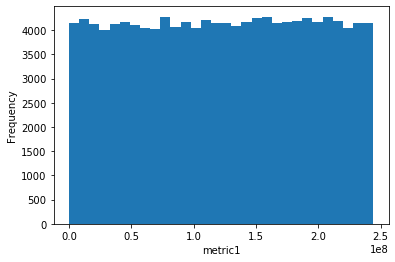

In [8]:
# looking at the distribution of values in metrics 1, 5 and 6
plt.hist(df['metric1'], bins=30)
plt.xlabel('metric1')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

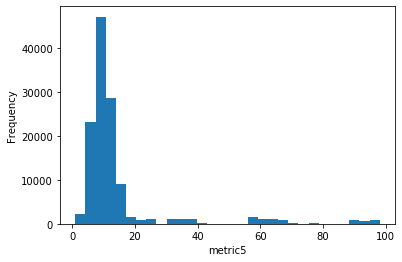

In [9]:
plt.hist(df['metric5'], bins=30)
plt.xlabel('metric5')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

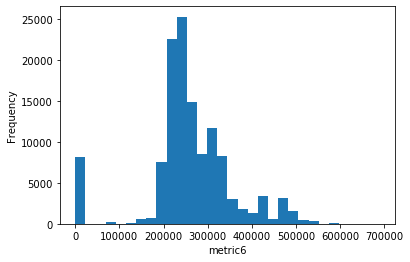

In [10]:
plt.hist(df['metric6'], bins=30)
plt.xlabel('metric6')
plt.ylabel('Frequency')

Text(0.5, 1.0, 'Metric1 vlaues with failure (failure = 1)')

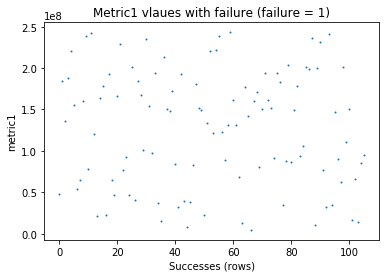

In [11]:
# confirms metric1 is not a good sources of info
plt.scatter(x=range(len(list(df['metric1'][df['failure']==1]))),
           y=df['metric1'][df['failure']==1], s=1)
plt.xlabel('Successes (rows)')
plt.ylabel('metric1')
plt.title('Metric1 vlaues with failure (failure = 1)')

Text(0.5, 1.0, 'Metric5 vlaues with failure (failure = 1)')

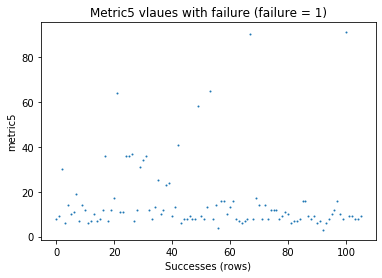

In [12]:
# most failures happend with metric 5 values between 0 and 20
plt.scatter(x=range(len(list(df['metric5'][df['failure']==1]))),
           y=df['metric5'][df['failure']==1], s=1)
plt.xlabel('Successes (rows)')
plt.ylabel('metric5')
plt.title('Metric5 vlaues with failure (failure = 1)')

Text(0.5, 1.0, 'Metric6 vlaues with failure (failure = 1)')

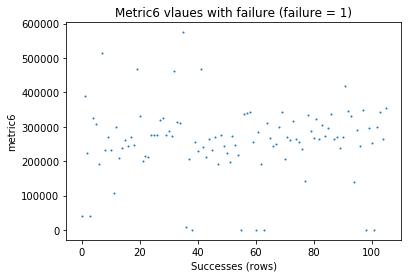

In [13]:
# most failures happend with metric 5 values between 200000 and 350000
plt.scatter(x=range(len(list(df['metric6'][df['failure']==1]))),
           y=df['metric6'][df['failure']==1], s=1)
plt.xlabel('Successes (rows)')
plt.ylabel('metric6')
plt.title('Metric6 vlaues with failure (failure = 1)')

In [14]:
# no useful correlation between metric1 and failure
# dropping not useful column
cols_to_drop2 = ['metric1']
df = df.drop(cols_to_drop2, axis=1)

In [15]:
# groups metric5 values into buckets by % of failure
# too many plot points for useful data
metric5_bucket = df.groupby(pd.cut(df['metric5'], bins=
                                  [x for x in range(0, 110, 10)]))
metric5_bucket = round((metric5_bucket.sum()['failure']/metric5_bucket.size())*100, 2)
metric5_bucket

metric5
(0, 10]      0.08
(10, 20]     0.08
(20, 30]     0.21
(30, 40]     0.21
(40, 50]     0.98
(50, 60]     0.05
(60, 70]     0.08
(70, 80]     0.00
(80, 90]     0.17
(90, 100]    0.06
dtype: float64

In [16]:
# groups metric6 values into buckets by % of failure
metric6_bucket = df.groupby(pd.cut(df['metric6'], bins=
                                   [x for x in range(0, 770000, 70000)]))
metric6_bucket = round((metric6_bucket.sum()['failure']/metric6_bucket.size())*100, 2)
metric6_bucket

metric6
(0, 70000]          0.11
(70000, 140000]     0.30
(140000, 210000]    0.09
(210000, 280000]    0.08
(280000, 350000]    0.11
(350000, 420000]    0.05
(420000, 490000]    0.04
(490000, 560000]    0.06
(560000, 630000]    2.13
(630000, 700000]    0.00
dtype: float64

Text(0.5, 1.0, '% of devices in metric5 group that failed')

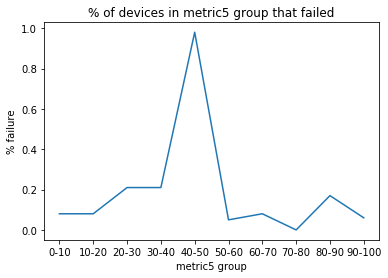

In [17]:
# plotting the buckets
x = [str(i)+'-'+str(i+10) for i in range(0, 100, 10)]
plt.plot(x, metric5_bucket.values)
plt.xlabel('metric5 group')
plt.ylabel('% failure')
plt.title('% of devices in metric5 group that failed')

Text(0.5, 1.0, '% of devices in metric6 group that failed')

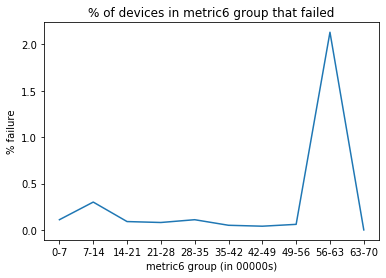

In [18]:
# plotting the buckets
x = [str(i)+'-'+str(i+7) for i in range(0, 70, 7)]
plt.plot(x, metric6_bucket.values)
plt.xlabel('metric6 group (in 00000s)')
plt.ylabel('% failure')
plt.title('% of devices in metric6 group that failed')

In [19]:
# replacing metric5 and metric6 colums with their respective buckets
df['metric5'] = pd.cut(df['metric5'], bins=
                       [x for x in range(0, 110, 10)])
df['metric6'] = pd.cut(df['metric6'], bins=[x for x in range(0, 770000, 70000)])

In [20]:
df = pd.get_dummies(df)
df.head()

,failure,"metric5_(0, 10]","metric5_(10, 20]","metric5_(20, 30]","metric5_(30, 40]","metric5_(40, 50]","metric5_(50, 60]","metric5_(60, 70]","metric5_(70, 80]","metric5_(80, 90]",...,"metric6_(0, 70000]","metric6_(70000, 140000]","metric6_(140000, 210000]","metric6_(210000, 280000]","metric6_(280000, 350000]","metric6_(350000, 420000]","metric6_(420000, 490000]","metric6_(490000, 560000]","metric6_(560000, 630000]","metric6_(630000, 700000]"
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [21]:
# dropping 2 dummy variable columns as they are implied
cols_to_drop3 = ['metric5_(0, 10]', 'metric6_(0, 70000]']
df = df.drop(cols_to_drop3, axis=1)

In [22]:
# saving a clean copy
df.to_csv('Clean_data.csv')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 19 columns):
failure                     124494 non-null int64
metric5_(10, 20]            124494 non-null uint8
metric5_(20, 30]            124494 non-null uint8
metric5_(30, 40]            124494 non-null uint8
metric5_(40, 50]            124494 non-null uint8
metric5_(50, 60]            124494 non-null uint8
metric5_(60, 70]            124494 non-null uint8
metric5_(70, 80]            124494 non-null uint8
metric5_(80, 90]            124494 non-null uint8
metric5_(90, 100]           124494 non-null uint8
metric6_(70000, 140000]     124494 non-null uint8
metric6_(140000, 210000]    124494 non-null uint8
metric6_(210000, 280000]    124494 non-null uint8
metric6_(280000, 350000]    124494 non-null uint8
metric6_(350000, 420000]    124494 non-null uint8
metric6_(420000, 490000]    124494 non-null uint8
metric6_(490000, 560000]    124494 non-null uint8
metric6_(560000, 630000]    124494 non-

In [24]:
feat = df.drop(columns=['failure'], axis=1)
label = df['failure']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(feat, label, test_size=0.3)

In [26]:
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.fit_transform(X_test)

In [27]:
support_vector_classifier = SVC(kernel='rbf')
support_vector_classifier.fit(X_train, y_train)
y_pred_svc = support_vector_classifier.predict(X_test)

In [28]:
cm_support_vector_classifier = confusion_matrix(y_test, y_pred_svc)

In [29]:
print(cm_support_vector_classifier, end='\n\n')

[[37312     0]
 [   37     0]]



In [30]:
num = cm_support_vector_classifier[0][0] + cm_support_vector_classifier[1][1]
den = sum(cm_support_vector_classifier[0]) + sum(cm_support_vector_classifier[1])
acc_svc = (num/den)*100
print('Accuracy: ', round(acc_svc, 2), '%')

Accuracy:  99.9 %


In [31]:
# using cross validation, rechecks the data model
cross_val_svc = cross_val_score(estimator=
                                SVC(kernel='rbf'),
                                   X=X_train, y=y_train, cv=10,
                                   n_jobs=-1)

print('Cross Validation Accruacy:', round(cross_val_svc.mean()
                                         *100, 2), '%')

Cross Validation Accruacy: 99.92 %
